# **üè† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä code**
> Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä ÏòàÏ∏° ÎåÄÌöåÏóê Ïò§Ïã† Ïó¨Îü¨Î∂Ñ ÌôòÏòÅÌï©ÎãàÎã§! üéâ

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î∂àÎü¨ÏòµÎãàÎã§.

In [42]:
# %pip install eli5==0.13.0

# # ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÇ¨Ïö©ÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.
!apt-get install -y fonts-nanum

# %pip install lightgbm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [43]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf ÌååÏùºÏù¥ Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäî Í≤ΩÎ°ú
    name='NanumBarunGothic')                        # Ïù¥ Ìè∞Ìä∏Ïùò ÏõêÌïòÎäî Ïù¥Î¶Ñ ÏÑ§Ï†ï
fm.fontManager.ttflist.insert(0, fe)              # MatplotlibÏóê Ìè∞Ìä∏ Ï∂îÍ∞Ä
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from sklearn.neighbors import BallTree
import re

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

# Network
import requests
import json

## 2. Data Load

#### 2.1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [44]:
# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º load ÌïòÍ≤†ÏäµÎãàÎã§. Í≤ΩÎ°úÎäî ÌôòÍ≤ΩÏóê ÎßûÍ≤å ÏßÄÏ†ïÌï¥Ï£ºÎ©¥ Îê©ÎãàÎã§.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
unique_addr_path = '../unique_address.csv'
unique_YX_poi_path = '/data/ephemeral/home/unique_YX_poi.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
duplicated_addr_df = pd.read_csv(unique_addr_path)
df_unique_YX = pd.read_csv(unique_YX_poi_path)

In [45]:
# Ïπ¥Ïπ¥Ïò§ API KEY Ï§ÄÎπÑ
# KAKAO_API_KEY = 'cb6d5d8a448c1a2344a636a2888775aa'

In [46]:
# Train dataÏôÄ Test data shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


## 3. Data Preprocessing

- Î™®Îç∏ÎßÅ Ï†ÑÏóê Îç∞Ïù¥ÌÑ∞ ÎÇ¥ Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò Îì±ÏùÑ Ï†úÍ±∞ÌïòÍ≥† Î≤îÏ£ºÌòïÍ≥º Ïó∞ÏÜçÌòï Î≥ÄÏàòÎ•º ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§!
- Î®ºÏ†Ä, Ïö©Ïù¥Ìïú Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ trainÍ≥º test dataÎ•º Ìï©Ïπú ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÏßÑÌñâÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [47]:
# train/test Íµ¨Î∂ÑÏùÑ ÏúÑÌïú ÏπºÎüºÏùÑ ÌïòÎÇò ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.

In [48]:
concat['is_test'].value_counts()      # trainÍ≥º test dataÍ∞Ä ÌïòÎÇòÎ°ú Ìï©Ï≥êÏßÑ Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

0    1118822
1       9272
Name: is_test, dtype: int64

In [49]:
# Ïª¨Îüº Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
concat = concat.rename(columns={'Ï†ÑÏö©Î©¥Ï†Å(„é°)':'Ï†ÑÏö©Î©¥Ï†Å',
                                'k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)':'Îã®ÏßÄÎ∂ÑÎ•ò', 
                                'k-Ï†ÑÌôîÎ≤àÌò∏':'Ï†ÑÌôîÎ≤àÌò∏', 
                                'k-Ìå©Ïä§Î≤àÌò∏':'Ìå©Ïä§Î≤àÌò∏',
                                'k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)':'ÏÑ∏ÎåÄÌÉÄÏûÖ',
                                'k-Í¥ÄÎ¶¨Î∞©Ïãù':'Í¥ÄÎ¶¨Î∞©Ïãù',
                                'k-Î≥µÎèÑÏú†Ìòï':'Î≥µÎèÑÏú†Ìòï', 
                                'k-ÎÇúÎ∞©Î∞©Ïãù':'ÎÇúÎ∞©Î∞©Ïãù',
                                'k-Ï†ÑÏ≤¥ÎèôÏàò':'Ï†ÑÏ≤¥ÎèôÏàò', 
                                'k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò':'Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò',
                                'k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)':'Í±¥ÏÑ§ÏÇ¨',
                                'k-ÏãúÌñâÏÇ¨':'ÏãúÌñâÏÇ¨',
                                'k-Ïó∞Î©¥Ï†Å':'Ïó∞Î©¥Ï†Å',
                                'k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å':'Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å',
                                'k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å':'Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å',
                                'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)':'Ï†ÑÏö©Î©¥Ï†Å<60',
                                'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)':'Ï†ÑÏö©Î©¥Ï†Å60~85',
                                'k-85„é°~135„é°Ïù¥Ìïò':'Ï†ÑÏö©Î©¥Ï†Å85~135',
                                'k-135„é°Ï¥àÍ≥º':'Ï†ÑÏö©Î©¥Ï†Å>135', 
                                'k-ÌôàÌéòÏù¥ÏßÄ':'ÌôàÌéòÏù¥ÏßÄ',
                                'k-Îì±Î°ùÏùºÏûê':'Îì±Î°ùÏùºÏûê', 
                                'k-ÏàòÏ†ïÏùºÏûê':'ÏàòÏ†ïÏùºÏûê'})

In [50]:
# Ï§ëÎ≥µÎêú Ìñâ Ïó¨Î∂ÄÎ•º ÎÇòÌÉÄÎÇ¥Îäî Î∂àÎ¶¨Ïñ∏ ÏãúÎ¶¨Ï¶à ÏÉùÏÑ±
duplicate_rows = concat.duplicated(subset=['ÎèÑÎ°úÎ™Ö'])

# Ï§ëÎ≥µÎêú ÌñâÏùò Ïàò Í≥ÑÏÇ∞
num_duplicates = duplicate_rows.sum()

print(f"'ÎèÑÎ°úÎ™Ö'ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ï§ëÎ≥µÎêú ÌñâÏùò Ïàò: {num_duplicates}Í∞ú")
print(f"Ï†ÑÏ≤¥ÏóêÏÑú Ï§ëÎ≥µÎêú Îç∞Ïù¥ÌÑ∞Î•º Î∫Ä Í∞úÏàò: {len(concat) - num_duplicates}Í∞ú")

'ÎèÑÎ°úÎ™Ö'ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ï§ëÎ≥µÎêú ÌñâÏùò Ïàò: 1118849Í∞ú
Ï†ÑÏ≤¥ÏóêÏÑú Ï§ëÎ≥µÎêú Îç∞Ïù¥ÌÑ∞Î•º Î∫Ä Í∞úÏàò: 9245Í∞ú


In [51]:
unique_addr_df = concat[['ÏãúÍµ∞Íµ¨', 'Î≤àÏßÄ', 'ÎèÑÎ°úÎ™Ö', 'ÏïÑÌååÌä∏Î™Ö', 'Ï¢åÌëúX', 'Ï¢åÌëúY']].drop_duplicates(subset='ÎèÑÎ°úÎ™Ö')
display(len(unique_addr_df))
display(unique_addr_df.head())

9245

ÏãúÍµ∞Íµ¨     Î≤àÏßÄ         ÎèÑÎ°úÎ™Ö     ÏïÑÌååÌä∏Î™Ö         Ï¢åÌëúX        Ï¢åÌëúY
0   ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô  658-1       Ïñ∏Ï£ºÎ°ú 3   Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±  127.057210  37.476763
12  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô    652     Í∞úÌè¨Î°ú 307   Í∞úÌè¨Ïö∞ÏÑ±3Ï∞®  127.055990  37.483894
25  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô   12-2  Í∞úÌè¨Î°ú109Í∏∏ 69     Í∞úÌè¨ÏûêÏù¥  127.076624  37.496296
38  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô    141     Í∞úÌè¨Î°ú 310  Í∞úÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ  127.058521  37.480002
44  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô    141       ÏÑ†Î¶âÎ°ú 7  Í∞úÌè¨Ï£ºÍ≥µ1Îã®ÏßÄ  127.058521  37.480002

In [52]:
display(concat.index)
display(unique_addr_df.index)
duplicated_addr_df.index = unique_addr_df.index
display(duplicated_addr_df.index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

In [53]:
# 'ÎèÑÎ°úÎ™Ö' Ïª¨ÎüºÏù¥ Î¨∏ÏûêÏó¥ ÌÉÄÏûÖÏù∏ÏßÄ ÌôïÏù∏ÌïòÍ≥† ÌÜµÏùºÌï©ÎãàÎã§.
concat['ÎèÑÎ°úÎ™Ö'] = concat['ÎèÑÎ°úÎ™Ö'].astype(str)
duplicated_addr_df['ÎèÑÎ°úÎ™Ö'] = duplicated_addr_df['ÎèÑÎ°úÎ™Ö'].astype(str)

In [54]:
# ÏÑúÎ∏å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú 'ÎèÑÎ°úÎ™Ö'ÏùÑ Ïù∏Îç±Ïä§Î°ú ÏÑ§Ï†ïÌï©ÎãàÎã§.
duplicated_addr_df.set_index('ÎèÑÎ°úÎ™Ö', inplace=True)

In [55]:
# ÏÑúÎ∏å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú 'Ï¢åÌëúX'ÏôÄ 'Ï¢åÌëúY'Ïùò ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
coord_x_map = duplicated_addr_df['Ï¢åÌëúX']
coord_y_map = duplicated_addr_df['Ï¢åÌëúY']

# Î©îÏù∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò 'Ï¢åÌëúX' Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞
concat['Ï¢åÌëúX'] = concat['Ï¢åÌëúX'].fillna(concat['ÎèÑÎ°úÎ™Ö'].map(coord_x_map))

# Î©îÏù∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò 'Ï¢åÌëúY' Í≤∞Ï∏°Ïπò Ï±ÑÏö∞Í∏∞
concat['Ï¢åÌëúY'] = concat['Ï¢åÌëúY'].fillna(concat['ÎèÑÎ°úÎ™Ö'].map(coord_y_map))

In [56]:
# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ìñâ ÌôïÏù∏
missing_coords = concat[concat['Ï¢åÌëúX'].isnull() | concat['Ï¢åÌëúY'].isnull()]
print(missing_coords)

Empty DataFrame
Columns: [ÏãúÍµ∞Íµ¨, Î≤àÏßÄ, Î≥∏Î≤à, Î∂ÄÎ≤à, ÏïÑÌååÌä∏Î™Ö, Ï†ÑÏö©Î©¥Ï†Å, Í≥ÑÏïΩÎÖÑÏõî, Í≥ÑÏïΩÏùº, Ï∏µ, Í±¥Ï∂ïÎÖÑÎèÑ, ÎèÑÎ°úÎ™Ö, Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº, Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê, Í±∞ÎûòÏú†Ìòï, Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ, Îã®ÏßÄÎ∂ÑÎ•ò, Ï†ÑÌôîÎ≤àÌò∏, Ìå©Ïä§Î≤àÌò∏, Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob, ÏÑ∏ÎåÄÌÉÄÏûÖ, Í¥ÄÎ¶¨Î∞©Ïãù, Î≥µÎèÑÏú†Ìòï, ÎÇúÎ∞©Î∞©Ïãù, Ï†ÑÏ≤¥ÎèôÏàò, Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò, Í±¥ÏÑ§ÏÇ¨, ÏãúÌñâÏÇ¨, k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº, Ïó∞Î©¥Ï†Å, Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å, Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å, Ï†ÑÏö©Î©¥Ï†Å<60, Ï†ÑÏö©Î©¥Ï†Å60~85, Ï†ÑÏö©Î©¥Ï†Å85~135, Ï†ÑÏö©Î©¥Ï†Å>135, ÌôàÌéòÏù¥ÏßÄ, Îì±Î°ùÏùºÏûê, ÏàòÏ†ïÏùºÏûê, Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏, Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú, ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï, Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú, Í±¥Ï∂ïÎ©¥Ï†Å, Ï£ºÏ∞®ÎåÄÏàò, Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4, Îã®ÏßÄÏäπÏù∏Ïùº, ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä, Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú, Ï¢åÌëúX, Ï¢åÌëúY, Îã®ÏßÄÏã†Ï≤≠Ïùº, target, is_test]
Index: []

[0 rows x 53 columns]


In [57]:
# ÏãúÍµ∞Íµ¨, ÎÖÑÏõî Îì± Î∂ÑÌï†Ìï† Ïàò ÏûàÎäî Î≥ÄÏàòÎì§ÏùÄ ÏÑ∏Î∂ÄÏÇ¨Ìï≠ Í≥†Î†§Î•º Ïö©Ïù¥ÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Î™®Îëê Î∂ÑÌï†Ìï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.
concat['Ïãú'] = concat['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[0])
concat['Íµ¨'] = concat['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[1])
concat['Îèô'] = concat['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[2])
del concat['ÏãúÍµ∞Íµ¨']

# Í≥ÑÏïΩÎÖÑÏõî split
concat['Í≥ÑÏïΩÎÖÑ'] = concat['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4])
concat['Í≥ÑÏïΩÏõî'] = concat['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[4:])
del concat['Í≥ÑÏïΩÎÖÑÏõî']

In [58]:
concat.columns

Index(['Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÎèÑÎ°úÎ™Ö', 'Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº',
       'Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê', 'Í±∞ÎûòÏú†Ìòï', 'Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ', 'Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï†ÑÌôîÎ≤àÌò∏', 'Ìå©Ïä§Î≤àÌò∏', 'Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob',
       'ÏÑ∏ÎåÄÌÉÄÏûÖ', 'Í¥ÄÎ¶¨Î∞©Ïãù', 'Î≥µÎèÑÏú†Ìòï', 'ÎÇúÎ∞©Î∞©Ïãù', 'Ï†ÑÏ≤¥ÎèôÏàò', 'Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'Í±¥ÏÑ§ÏÇ¨', 'ÏãúÌñâÏÇ¨',
       'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'Ïó∞Î©¥Ï†Å', 'Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'Ï†ÑÏö©Î©¥Ï†Å<60', 'Ï†ÑÏö©Î©¥Ï†Å60~85',
       'Ï†ÑÏö©Î©¥Ï†Å85~135', 'Ï†ÑÏö©Î©¥Ï†Å>135', 'ÌôàÌéòÏù¥ÏßÄ', 'Îì±Î°ùÏùºÏûê', 'ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú',
       'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4', 'Îã®ÏßÄÏäπÏù∏Ïùº',
       'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'target', 'is_test', 'Ïãú',
       'Íµ¨', 'Îèô'

In [59]:
# Í∞Å Ïª¨Îüº Î≥Ñ Í∞íÏùÑ Î≥ÄÍ≤Ω
concat['Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê'] = concat['Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê'].replace(' ', np.nan)
concat['Í±∞ÎûòÏú†Ìòï'] = concat['Í±∞ÎûòÏú†Ìòï'].replace('-', np.nan)
concat['Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ'] = concat['Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ'].replace('-', np.nan)
# concat.loc[concat['Ï∏µ'] < 0, 'Ï∏µ'] = 1
concat['Îã®ÏßÄÎ∂ÑÎ•ò'] = concat['Îã®ÏßÄÎ∂ÑÎ•ò'].replace('ÎèÑÏãúÌòï ÏÉùÌôúÏ£ºÌÉù(Ï£ºÏÉÅÎ≥µÌï©)', 'Ï£ºÏÉÅÎ≥µÌï©')
concat['Îã®ÏßÄÎ∂ÑÎ•ò'] = concat['Îã®ÏßÄÎ∂ÑÎ•ò'].replace('ÎèÑÏãúÌòï ÏÉùÌôúÏ£ºÌÉù(ÏïÑÌååÌä∏)', 'ÏïÑÌååÌä∏')
concat['ÏïÑÌååÌä∏Î™Ö'] = concat['ÏïÑÌååÌä∏Î™Ö'].fillna('Ïù¥Î¶ÑÏóÜÏùå')

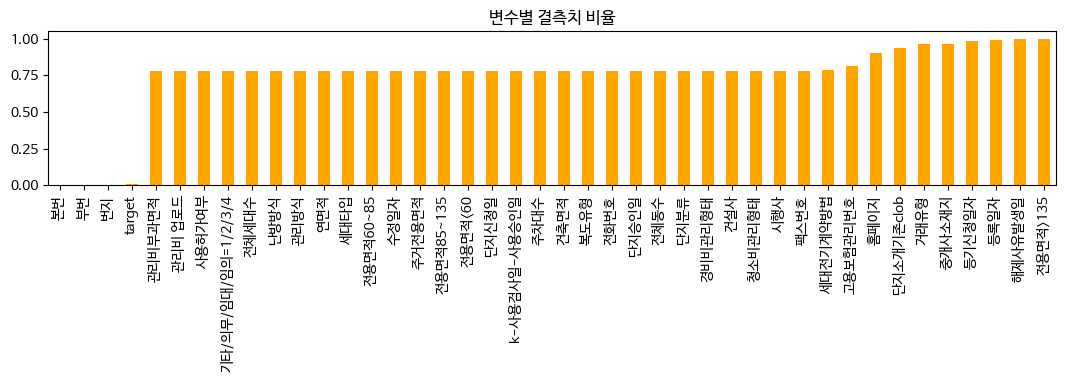

In [60]:
# Î≥ÄÏàòÎ≥Ñ Í≤∞Ï∏°ÏπòÏùò ÎπÑÏú®ÏùÑ plotÏúºÎ°ú Í∑∏Î†§Î≥¥Î©¥ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('Î≥ÄÏàòÎ≥Ñ Í≤∞Ï∏°Ïπò ÎπÑÏú®')
plt.show()

In [61]:
# NullÍ∞íÏù¥ 100ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ ÏπºÎüºÏùÄ ÏÇ≠Ï†úÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
print('* Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§ :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # ÎÇ®Í≤®Ïßà Î≥ÄÏàòÎì§ÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print('* Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ Î≥ÄÏàòÎì§ :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§ : ['Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÎèÑÎ°úÎ™Ö', 'Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï†ÑÌôîÎ≤àÌò∏', 'Ìå©Ïä§Î≤àÌò∏', 'ÏÑ∏ÎåÄÌÉÄÏûÖ', 'Í¥ÄÎ¶¨Î∞©Ïãù', 'Î≥µÎèÑÏú†Ìòï', 'ÎÇúÎ∞©Î∞©Ïãù', 'Ï†ÑÏ≤¥ÎèôÏàò', 'Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'Í±¥ÏÑ§ÏÇ¨', 'ÏãúÌñâÏÇ¨', 'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'Ïó∞Î©¥Ï†Å', 'Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'Ï†ÑÏö©Î©¥Ï†Å<60', 'Ï†ÑÏö©Î©¥Ï†Å60~85', 'Ï†ÑÏö©Î©¥Ï†Å85~135', 'ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4', 'Îã®ÏßÄÏäπÏù∏Ïùº', 'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'target', 'is_test', 'Ïãú', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî']
* Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ Î≥ÄÏàòÎì§ : ['Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº', 'Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê', 'Í±∞ÎûòÏú†Ìòï', 'Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ', 'Îã®ÏßÄÏÜå

In [62]:
# ÏúÑÏóêÏÑú Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§Îßå Í≥®Îùº ÏÉàÎ°úÏö¥ concat_select Í∞ùÏ≤¥Î°ú Ï†ÄÏû•Ìï¥Ï§çÎãàÎã§.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
dt_concat_select = concat[selected]

In [63]:
# # Î≥∏Î≤à, Î∂ÄÎ≤àÏùò Í≤ΩÏö∞ floatÎ°ú ÎêòÏñ¥ÏûàÏßÄÎßå Î≤îÏ£ºÌòï Î≥ÄÏàòÏùò ÏùòÎØ∏Î•º Í∞ÄÏßÄÎØÄÎ°ú object(string) ÌòïÌÉúÎ°ú Î∞îÍæ∏Ïñ¥Ï£ºÍ≥† ÏïÑÎûò ÏûëÏóÖÏùÑ ÏßÑÌñâÌïòÍ≤†ÏäµÎãàÎã§.
# dt_concat_select['Î≥∏Î≤à'] = dt_concat_select['Î≥∏Î≤à'].astype('str')
# dt_concat_select['Î∂ÄÎ≤à'] = dt_concat_select['Î∂ÄÎ≤à'].astype('str')

In [64]:
dt_concat_select['is_test'].value_counts()      # trainÍ≥º test dataÍ∞Ä ÌïòÎÇòÎ°ú Ìï©Ï≥êÏßÑ Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

0    1118822
1       9272
Name: is_test, dtype: int64

In [65]:
# ÌïôÏäµÍ≥º ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
dt_train = dt_concat_select.query('is_test==0')
dt_test = dt_concat_select.query('is_test==1')

In [66]:
# ÌîºÏ≥ê ÎìúÎûçÌïòÍ∏∞ Ïù¥Ï†ÑÏ§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ÌõÑ Ï†úÍ±∞  
pd.Series(dt_train.duplicated()).value_counts()
dt_train[dt_train.duplicated(keep=False)].sort_values(by=list(dt_train.columns)).head(10)
dt_train = dt_train.drop_duplicates(keep='first')
pd.Series(dt_train.duplicated()).value_counts()

False    1115737
dtype: int64

In [67]:
# target Îç∞Ïù¥ÌÑ∞Ïóê Î°úÍ∑∏ Î≥ÄÌôòÏùÑ ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞Ïùò Ïä§ÏºÄÏùºÏùÑ ÏûëÍ≤å ÎßåÎì§Ïñ¥ Îç∞Ïù¥ÌÑ∞ Í∞ÑÏùò Ìé∏Ï∞®Î•º Ï§ÑÏûÖÎãàÎã§.
dt_train['target'] = np.log1p(dt_train['target'])

In [68]:
dt_concat_select = pd.concat([dt_train, dt_test])     # ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎßåÎì§Ïñ¥Ï§çÎãàÎã§.

In [69]:
dt_concat_select['is_test'].value_counts()      # trainÍ≥º test dataÍ∞Ä ÌïòÎÇòÎ°ú Ìï©Ï≥êÏßÑ Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

0    1115737
1       9272
Name: is_test, dtype: int64

In [70]:
dt_concat_select.shape

(1125009, 48)

In [71]:
# # ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàòÎì§ÏùÑ Ï†úÍ±∞
columns_to_drop = ['Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò']
dt_concat_select = dt_concat_select.drop(columns=columns_to_drop)

### Î≤îÏ£ºÌòï/Ïó∞ÏÜçÌòï baseline Î≥ÄÏàò Î≥¥Í∞Ñ

In [72]:
# # Ïó∞ÏÜçÌòï Î≥ÄÏàòÏôÄ Î≤îÏ£ºÌòï Î≥ÄÏàòÎ•º ÏúÑ infoÏóê Îî∞Îùº Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
# continuous_columns = []
# categorical_columns = []

# for column in dt_concat_select.columns:
#     if pd.api.types.is_numeric_dtype(dt_concat_select[column]):
#         continuous_columns.append(column)
#     else:
#         categorical_columns.append(column)

# print("Ïó∞ÏÜçÌòï Î≥ÄÏàò:", continuous_columns)
# print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns)

In [73]:
# # Î≤îÏ£ºÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ
# dt_concat_select[categorical_columns] = dt_concat_select[categorical_columns].fillna('NULL')

# # Ïó∞ÏÜçÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ (ÏÑ†Ìòï Î≥¥Í∞Ñ)
# dt_concat_select[continuous_columns] = dt_concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [74]:
# dt_concat_select.isnull().sum()         # Í≤∞Ï∏°ÏπòÍ∞Ä Î≥¥Í∞ÑÎêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï¥Î¥ÖÎãàÎã§.

### Î≥ÄÏàò Î≥¥Í∞Ñ

In [75]:
# ÏúÑÏóêÏÑú ÌîºÏ≥ê ÎìúÎûçÏùÑ ÌñàÏúºÎãà Îã§Ïãú Î≤îÏ£ºÌòï, Ïó∞ÏÜçÌòï Î≥ÄÏàò Î∂ÑÎ¶¨
continuous_columns = []
categorical_columns = []

for column in dt_concat_select.columns:
    if pd.api.types.is_numeric_dtype(dt_concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("Ïó∞ÏÜçÌòï Î≥ÄÏàò:", continuous_columns)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns)

Ïó∞ÏÜçÌòï Î≥ÄÏàò: ['Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'Ï†ÑÏ≤¥ÎèôÏàò', 'Ïó∞Î©¥Ï†Å', 'Ï†ÑÏö©Î©¥Ï†Å<60', 'Ï†ÑÏö©Î©¥Ï†Å60~85', 'Ï†ÑÏö©Î©¥Ï†Å85~135', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'target', 'is_test']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['Î≤àÏßÄ', 'ÏïÑÌååÌä∏Î™Ö', 'ÎèÑÎ°úÎ™Ö', 'Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï†ÑÌôîÎ≤àÌò∏', 'Ìå©Ïä§Î≤àÌò∏', 'ÏÑ∏ÎåÄÌÉÄÏûÖ', 'Í¥ÄÎ¶¨Î∞©Ïãù', 'Î≥µÎèÑÏú†Ìòï', 'ÎÇúÎ∞©Î∞©Ïãù', 'Í±¥ÏÑ§ÏÇ¨', 'ÏãúÌñâÏÇ¨', 'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4', 'Îã®ÏßÄÏäπÏù∏Ïùº', 'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú', 'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'Ïãú', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî']


In [76]:
# dt_concat_select['Ï∏µ'] = np.log1p(dt_concat_select['Ï∏µ'])

In [77]:
# # ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
# fig = plt.figure(figsize=(7, 3))
# sns.histplot(data = dt_concat_select, x = "Ï∏µ", color="lightgreen")
# plt.title("Ï∏µ")
# plt.xlabel('Area')
# plt.show()

In [78]:
# dt_temp = dt_temp.dropna(subset=['ÏïÑÌååÌä∏Î™Ö', 'Î≤àÏßÄ'])

In [79]:
# # Ï†ÑÏ≤¥ÎèôÏàò (Í∏∞Ï§Ä: ÏïÑÌååÌä∏Î™Ö, Îèô)
# def regression_imputation(df = dt_temp):
#     # Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäî Îç∞Ïù¥ÌÑ∞Î°ú Î™®Îç∏ ÌïôÏäµ
#     df_train = df.dropna(subset=['Ï†ÑÏ≤¥ÎèôÏàò']).reset_index(drop=True)
    
#     # Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏ÏΩîÎî©
#     df_encoded = df.copy().reset_index(drop=True)
#     df_encoded['ÏïÑÌååÌä∏Î™Ö_encoded'] = LabelEncoder().fit_transform(df['ÏïÑÌååÌä∏Î™Ö'])
#     df_encoded['Îèô_encoded'] = LabelEncoder().fit_transform(df['Îèô'])
    
#     # Î™®Îç∏ ÌïôÏäµ
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     X_train = df_encoded.loc[df_train.index, ['ÏïÑÌååÌä∏Î™Ö_encoded', 'Îèô_encoded']]
#     y_train = df_train['Ï†ÑÏ≤¥ÎèôÏàò']
#     model.fit(X_train, y_train)
    
#     # Í≤∞Ï∏°Ïπò ÏòàÏ∏°
#     mask = df['Ï†ÑÏ≤¥ÎèôÏàò'].isna()
#     X_missing = df_encoded.loc[mask.reset_index(drop=True), ['ÏïÑÌååÌä∏Î™Ö_encoded', 'Îèô_encoded']]
#     df.loc[mask, 'Ï†ÑÏ≤¥ÎèôÏàò'] = model.predict(X_missing)
    
#     return df

In [80]:
# Ï†ÅÏö©
# dt_concat_select = regression_imputation(df = dt_temp)

In [81]:
# dt_concat_select['Ï†ÑÏ≤¥ÎèôÏàò']

In [82]:
# Î≤îÏ£ºÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ
dt_concat_select[categorical_columns] = dt_concat_select[categorical_columns].fillna('NULL')

# Ïó∞ÏÜçÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ (ÏÑ†Ìòï Î≥¥Í∞Ñ)
dt_concat_select[continuous_columns] = dt_concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [83]:
# ÌäπÏàò Î¨∏ÏûêÎ•º Î∞ëÏ§ÑÎ°ú ÎåÄÏ≤¥ÌïòÎäî Ìï®Ïàò
def clean_column_names(df):
    df.columns = [re.sub(r'\W+', '_', col) for col in df.columns]
    return df
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò ÌîºÏ≤ò Ïù¥Î¶Ñ Ï†ïÎ¶¨ (LGBRegressor ÏóêÏÑú Î≥ÄÏàòÎ™ÖÏù¥ Î¨∏Ï†úÍ∞Ä ÏÉùÍπÄ)
dt_concat_select = clean_column_names(dt_concat_select)

display(dt_concat_select.columns)
display(dt_concat_select.shape)

Index(['Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÎèÑÎ°úÎ™Ö', 'Îã®ÏßÄÎ∂ÑÎ•ò',
       'Ï†ÑÌôîÎ≤àÌò∏', 'Ìå©Ïä§Î≤àÌò∏', 'ÏÑ∏ÎåÄÌÉÄÏûÖ', 'Í¥ÄÎ¶¨Î∞©Ïãù', 'Î≥µÎèÑÏú†Ìòï', 'ÎÇúÎ∞©Î∞©Ïãù', 'Ï†ÑÏ≤¥ÎèôÏàò', 'Í±¥ÏÑ§ÏÇ¨', 'ÏãúÌñâÏÇ¨',
       'k_ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº_ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'Ïó∞Î©¥Ï†Å', 'Ï†ÑÏö©Î©¥Ï†Å_60', 'Ï†ÑÏö©Î©¥Ï†Å60_85', 'Ï†ÑÏö©Î©¥Ï†Å85_135', 'ÏàòÏ†ïÏùºÏûê',
       'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò',
       'Í∏∞ÌÉÄ_ÏùòÎ¨¥_ÏûÑÎåÄ_ÏûÑÏùò_1_2_3_4', 'Îã®ÏßÄÏäπÏù∏Ïùº', 'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑ_ÏóÖÎ°úÎìú', 'Ï¢åÌëúX', 'Ï¢åÌëúY',
       'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'target', 'is_test', 'Ïãú', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî'],
      dtype='object')

(1125009, 45)

### 3.2. Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨
- Ïù¥Î≤àÏóî Ïù¥ÏÉÅÏπòÎ•º Ï≤òÎ¶¨Ìï¥Î¥ÖÏãúÎã§.
- Ïù¥ÏÉÅÏπòÎ•º Ï≤òÎ¶¨ÌïòÎäî Î∞©Î≤ïÏùÄ IQR, Z-score Îì± Îã§ÏñëÌïú Î∞©Î≤ïÏù¥ ÏûàÏäµÎãàÎã§. Í∞ÄÏû• ÏâΩÍ≥† ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú Ï†ëÍ∑ºÌïòÎäî Î∞©Î≤ïÏùÄ Í∏∞Î≥∏ ÌÜµÍ≥ÑÏπòÎ•º Ïù¥Ïö©ÌïòÎäî Í≤ÉÏûÖÎãàÎã§.

In [84]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ïù¥Ï†ÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print(dt_concat_select.shape)

(1125009, 45)


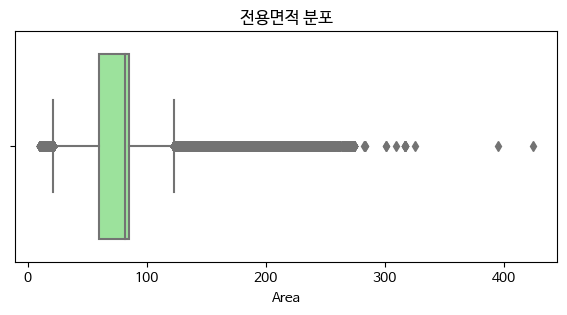

In [85]:
# ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt_concat_select, x = "Ï†ÑÏö©Î©¥Ï†Å", color="lightgreen")
plt.title("Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨")
plt.xlabel('Area')
plt.show()

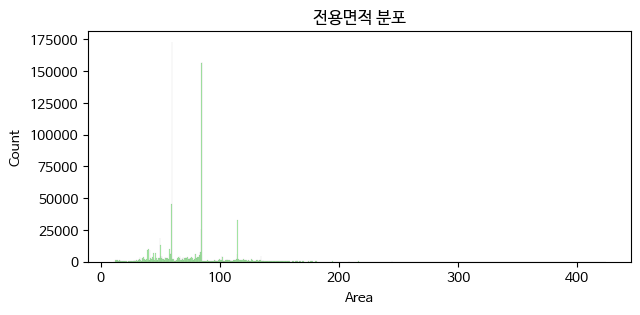

In [86]:
# ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.histplot(data = dt_concat_select, x = "Ï†ÑÏö©Î©¥Ï†Å", color="lightgreen")
plt.title("Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨")
plt.xlabel('Area')
plt.show()

In [87]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Î∞©Î≤ïÏóêÎäî IQRÏùÑ Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data ÎÇ¥Ïóê ÏûàÎäî Ïù¥ÏÉÅÏπòÎßå Ï†úÍ±∞ÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test dataÏôÄ Îã§Ïãú Ìï©Ï≥êÏ£ºÍ≤†ÏäµÎãàÎã§.
    return result

In [88]:
# ÏúÑ Î∞©Î≤ïÏúºÎ°ú Ï†ÑÏö© Î©¥Ï†ÅÏóê ÎåÄÌïú Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.
dt_concat_select = remove_outliers_iqr(dt_concat_select, 'Ï†ÑÏö©Î©¥Ï†Å')

In [89]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. ÏïΩ 10ÎßåÍ∞úÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†úÍ±∞Îêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
print(dt_concat_select.shape)

(1036122, 45)


## 4. Feature Engineering
- Ïù¥Ï†ú ÌååÏÉùÎ≥ÄÏàòÎ•º ÎßåÎì§Ïñ¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
- ÌååÏÉù Î≥ÄÏàòÎäî ÎèÑÎ©îÏù∏ ÏßÄÏãùÏóê Í∏∞Î∞òÌï¥ Ï†úÏûëÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌï©ÎãàÎã§.
- Ï£ºÌÉùÏùò Í∞ÄÍ≤©ÏùÑ ÏòàÏ∏°ÌïòÎäî Î¨∏Ï†úÏù¥Í∏∞ ÎïåÎ¨∏Ïóê ÏïΩÍ∞ÑÏùò Î∂ÄÎèôÏÇ∞ ÏßÄÏãùÏùÑ Í∏∞Î∞òÏúºÎ°ú ÌååÏÉù Î≥ÄÏàòÎ•º ÎßåÎì§Ïñ¥ Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [90]:
# Íµ¨ Ìã∞Ïñ¥ 
goo = list(dt_concat_select['Íµ¨'].unique())

tier1 = ['Í∞ïÎÇ®Íµ¨', 'ÏÑúÏ¥àÍµ¨', 'Ïö©ÏÇ∞Íµ¨', 'ÏÜ°ÌååÍµ¨', 'ÏÑ±ÎèôÍµ¨']
tier2 = ['ÎßàÌè¨Íµ¨', 'Í¥ëÏßÑÍµ¨', 'ÎèôÏûëÍµ¨', 'ÏòÅÎì±Ìè¨Íµ¨', 'Ï§ëÍµ¨', 'Ï¢ÖÎ°úÍµ¨', 'Í∞ïÎèôÍµ¨', 'ÏñëÏ≤úÍµ¨', 'ÏÑúÎåÄÎ¨∏Íµ¨']
tier3 = [x for x in goo if x not in tier1 + tier2]

assert len(goo) == len(tier1) + len(tier2) + len(tier3)       # ÏïåÎßûÍ≤å Î∂ÑÎ¶¨ÎêòÏóàÎäîÏßÄ Ï≤¥ÌÅ¨Ìï©ÎãàÎã§.

In [91]:
# Í∞ïÎÇ®Ïùò Ïó¨Î∂ÄÎ•º Ï≤¥ÌÅ¨Ìï©ÎãàÎã§.
goo_tier = []
for x in dt_concat_select['Íµ¨'].tolist() :
  if x in tier1 :
    goo_tier.append(1)  
  elif x in tier2 :
    goo_tier.append(2)
  else :
    goo_tier.append(3)

# ÌååÏÉùÎ≥ÄÏàòÎ•º ÌïòÎÇò ÎßåÎ¶ÖÎãàÎã§.
dt_concat_select['Íµ¨ Ìã∞Ïñ¥'] = goo_tier

In [92]:
# Îèô Ìã∞Ïñ¥
dong = list(dt_concat_select['Îèô'].unique())

# Define tiers
t1 = ['Î∞òÌè¨Îèô', 'Í∞úÌè¨Îèô', 'ÏïïÍµ¨Ï†ïÎèô', 'ÎåÄÏπòÎèô', 'Ïû†ÏõêÎèô', 'Ïû†Ïã§Îèô', 'ÏùºÏõêÎèô', 'ÏàòÏÑúÎèô', 'ÌèâÎèô', 'ÌôçÌååÎèô', 'ÏÇºÏÑ±Îèô', 'Ï≤≠Îã¥Îèô', 'ÎèÑÍ≥°Îèô', 'ÍµêÎ∂ÅÎèô', 'ÏÑ±ÏàòÎèô1Í∞Ä', 'ÌïúÎÇ®Îèô', 'Ïö©Í∞ïÎèô']
t2 = ['ÏïÑÌòÑÎèô', 'Ïã†Í≥ÑÎèô', 'Ïã†Ï≤úÎèô', 'Ïó≠ÏÇºÎèô', 'Î≥¥Í¥ëÎèô', 'Ïö©ÏÇ∞Îèô5Í∞Ä', 'Î∂ÅÏïÑÌòÑÎèô', 'ÎßåÎ¶¨Îèô2Í∞Ä','Ïö©Î¨∏Îèô', 'ÏûêÍ≥°Îèô', 'Ïã†ÏõêÎèô', 'Ïù¥Ï¥åÎèô', 'ÏÑ±ÏàòÎèô2Í∞Ä', 'ÏÉÅÏàòÎèô', 'ÏÑúÎπôÍ≥†Îèô', 'Ïò•ÏàòÎèô', 'Í∏àÌò∏Îèô4Í∞Ä', 'Í≥†ÎçïÎèô', 'Í∏àÌò∏Îèô2Í∞Ä', 'ÏÑ∏Í≥°Îèô', 'Ïû•ÏßÄÎèô', 'ÌòÑÏÑùÎèô', 'ÎÇ¥Í≥°Îèô']
t3 = ['ÏÉÅÏôïÏã≠Î¶¨Îèô', 'Ïö∞Î©¥Îèô', 'ÏóºÎ¶¨Îèô', 'ÌùëÏÑùÎèô', 'ÏÑúÏ¥àÎèô', 'ÌïúÍ∞ïÎ°ú3Í∞Ä', 'ÎÖºÌòÑÎèô', 'Ïó¨ÏùòÎèÑÎèô', 'Î∞©Î∞∞Îèô', 'ÎåÄÌù•Îèô', 'Í¥ëÏû•Îèô', 'ÏÉÅÏùºÎèô', 'Í≥µÎçïÎèô', 'ÌïúÍ∞ïÎ°ú1Í∞Ä', 'Î∞©Ïù¥Îèô', 'ÏòÅÎì±Ìè¨Îèô7Í∞Ä', 'ÌÜ†Ï†ïÎèô', 'Ï§ëÎ¶ºÎèô', 'Í∏àÌò∏Îèô1Í∞Ä', 'ÏõêÌö®Î°ú4Í∞Ä', 'ÌñâÎãπÎèô', 'Ïã†Í≥µÎçïÎèô', 'ÌïòÏôïÏã≠Î¶¨Îèô', 'ÏõêÌö®Î°ú1Í∞Ä', 'ÎèôÏûëÎèô', 'ÏÜ°ÌååÎèô', 'ÎßåÎ¶¨Îèô1Í∞Ä', 'Ïù¥ÌÉúÏõêÎèô', 'Î™©Îèô']


# Convert back to list if needed
t4 = [x for x in dong if x not in t1 + t2 + t3]

# # Check if all 'dong' are categorized
assert len(dong) == len(t1) + len(t2) + len(t3) + len(t4), "Mismatch in tier categorization"

In [93]:
dong_tier = []
for x in dt_concat_select['Îèô'].tolist() :
    if x in t1 :
        dong_tier.append(1)
    elif x in t2 :
        dong_tier.append(2)
    else :
        dong_tier.append(3)
dt_concat_select['Îèô Ìã∞Ïñ¥'] = dong_tier

In [94]:
# Í±¥Ï∂ïÎÖÑÎèÑ Î∂ÑÌè¨Îäî ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. ÌäπÌûà 2005ÎÖÑÏù¥ Q3Ïóê Ìï¥ÎãπÌï©ÎãàÎã§.
# 2009ÎÖÑ Ïù¥ÌõÑÏóê ÏßÄÏñ¥ÏßÑ Í±¥Î¨ºÏùÄ 10%Ï†ïÎèÑ ÎêòÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
dt_concat_select['Í±¥Ï∂ïÎÖÑÎèÑ'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.036122e+06
mean     1.998577e+03
std      9.127290e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: Í±¥Ï∂ïÎÖÑÎèÑ, dtype: float64

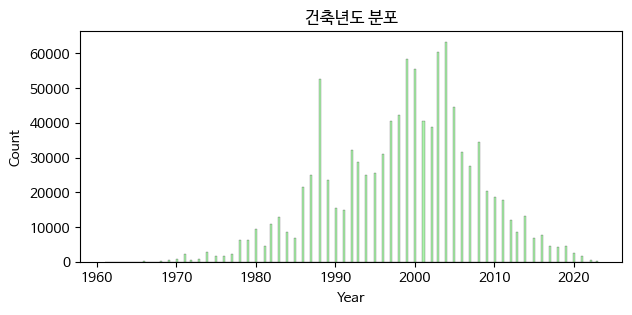

In [95]:
# ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.histplot(data = dt_concat_select, x = "Í±¥Ï∂ïÎÖÑÎèÑ", color="lightgreen")
plt.title("Í±¥Ï∂ïÎÖÑÎèÑ Î∂ÑÌè¨")
plt.xlabel('Year')
plt.show()

In [96]:
# Îî∞ÎùºÏÑú 2009ÎÖÑ Ïù¥ÌõÑÏóê ÏßÄÏñ¥Ï°åÏúºÎ©¥ ÎπÑÍµêÏ†Å Ïã†Ï∂ïÏù¥ÎùºÍ≥† ÌåêÎã®ÌïòÍ≥†, Ïã†Ï∂ï Ïó¨Î∂Ä Î≥ÄÏàòÎ•º Ï†úÏûëÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
dt_concat_select['Ïã†Ï∂ïÏó¨Î∂Ä'] = dt_concat_select['Í±¥Ï∂ïÎÖÑÎèÑ'].apply(lambda x: 1 if x >= 2009 else 0)

### POI Í∞úÏàò
- Ïπ¥Ïπ¥Ïò§ APIÎ•º ÌôúÏö©ÌïòÏó¨ ÏñªÏóàÏäµÎãàÎã§. ÏßÄÍ∏àÏùÄ Ï†ÄÏû•Îêú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôÄ ÌôúÏö©Ìï©ÎãàÎã§.

In [97]:
display(df_unique_YX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ï¢åÌëúY     8345 non-null   float64
 1   Ï¢åÌëúX     8345 non-null   float64
 2   POI_Í∞úÏàò  8345 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 195.7 KB


None

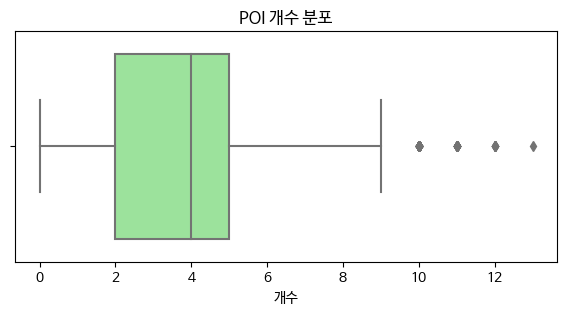

In [98]:
# ‚ÄúPOI_Í∞úÏàò‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = df_unique_YX, x = "POI_Í∞úÏàò", color="lightgreen")
plt.title("POI Í∞úÏàò Î∂ÑÌè¨")
plt.xlabel('Í∞úÏàò')
plt.show()

In [99]:
# Î©îÏù∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÍ≥º ÏÑúÎ∏å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Î≥ëÌï©
dt_concat_select = pd.merge(dt_concat_select, df_unique_YX, on=['Ï¢åÌëúY', 'Ï¢åÌëúX'], how='left')

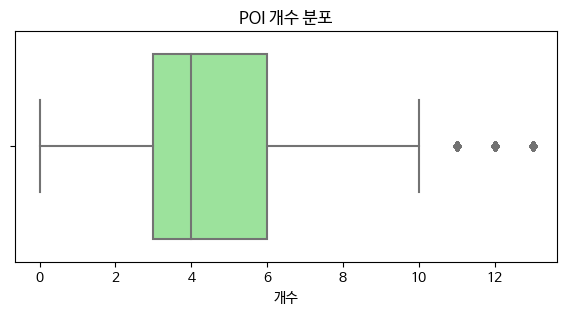

In [100]:
# Î≥ëÌï© ÌõÑ Î©îÏù∏ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùò ‚ÄúPOI_Í∞úÏàò‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt_concat_select, x = "POI_Í∞úÏàò", color="lightgreen")
plt.title("POI Í∞úÏàò Î∂ÑÌè¨")
plt.xlabel('Í∞úÏàò')
plt.show()

In [101]:
# ÏúÑ Î∞©Î≤ïÏúºÎ°ú Ï†ÑÏö© Î©¥Ï†ÅÏóê ÎåÄÌïú Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.
dt_concat_select = remove_outliers_iqr(dt_concat_select, 'POI_Í∞úÏàò')

#### ÏïÑÌååÌä∏ Î∏åÎûúÎìú

In [102]:
# Î∏åÎûúÎìúÎ≥Ñ Ïπ¥ÌÖåÍ≥†Î¶¨Ìôî
def categorize_brand(brand):
    if any(b in brand for b in ['ÎîîÏóêÏù¥Ïπò', 'Ìë∏Î•¥ÏßÄÏò§Ïç®Î∞ã', 'Î•¥Ïóò', 'Ïò§Ìã∞ÏóêÎ•¥', 'ÏïÑÌÅ¨Î°ú', 'ÏúÑÎ∏åÎçîÏ†úÎãàÏä§', 'Ïç®Î∞ã', 'ÎìúÌååÏù∏']):
        return 'ÌïòÏù¥ÏóîÎìú'
    elif any(b in brand for b in ['ÌûêÏä§ÌÖåÏù¥Ìä∏', 'Ìë∏Î•¥ÏßÄÏò§', 'Î°ØÎç∞Ï∫êÏä¨','ÎçîÏÉµ', 'eÌé∏ÌïúÏÑ∏ÏÉÅ','ÎûòÎØ∏Ïïà','ÏïÑÏù¥ÌååÌÅ¨','ÏúÑÎ∏å', 'Ïö∞ÎØ∏Î¶∞', 'ÌïúÌôîÌè¨Î†àÎÇò', 'ÏÑúÌù¨Ïä§ÌÉÄÌûêÏä§','ÎçîÌîåÎûòÌã∞ÎÑò','ÌïúÎùºÎπÑÎ∞úÎîî','Ìò∏Î∞òÎ≤†Î•¥ÎîîÏõÄ','Îç∞ÏãúÏïô','ÏÑºÌä∏Î†àÎπå','ÏûêÏù¥','SKÎ∑∞','ÌïòÎäòÏ±Ñ','Ïä§ÏúÑÏ≤∏']):
        return '1Íµ∞'
    else:
        return 'Í∏∞ÌÉÄ'

dt_concat_select['Î∏åÎûúÎìúÎì±Í∏â'] = dt_concat_select['ÏïÑÌååÌä∏Î™Ö'].apply(categorize_brand)

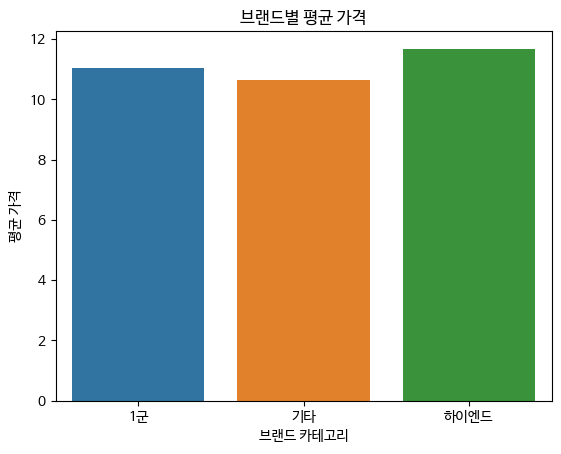

In [103]:
# Î∏åÎûúÎìúÎ≥Ñ ÌèâÍ∑† Í∞ÄÍ≤©
brand_avg_price = dt_concat_select.groupby('Î∏åÎûúÎìúÎì±Í∏â')['target'].mean().reset_index()

# ÏãúÍ∞ÅÌôî
sns.barplot(x='Î∏åÎûúÎìúÎì±Í∏â', y='target', data=brand_avg_price)
plt.title('Î∏åÎûúÎìúÎ≥Ñ ÌèâÍ∑† Í∞ÄÍ≤©')
plt.xlabel('Î∏åÎûúÎìú Ïπ¥ÌÖåÍ≥†Î¶¨')
plt.ylabel('ÌèâÍ∑† Í∞ÄÍ≤©')
plt.show()

#### ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌôïÏù∏
- Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å, Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å, Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàòÏôÄ ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î≥¥ÏûÑ

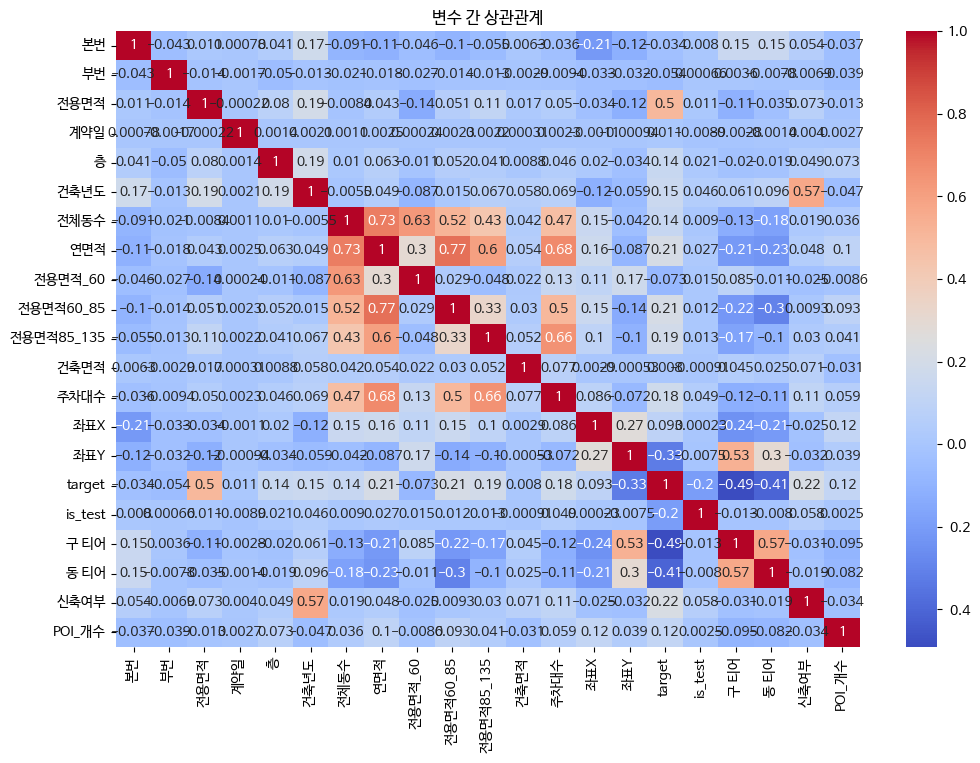

In [104]:
# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌñâÎ†¨ Í≥ÑÏÇ∞
corr_matrix = dt_concat_select.corr()

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Î≥ÄÏàò Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ')
plt.show()

## 5. Model Training

- Ïù¥Ï†ú ÏúÑÏóêÏÑú ÎßåÎì† ÌååÏÉùÎ≥ÄÏàòÎì§Í≥º Ï†ïÏ†úÌïú Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Î≥∏Í≤©Ï†ÅÏúºÎ°ú Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞ÄÎ•º ÏòàÏ∏°ÌïòÎäî Î™®Îç∏ÎßÅÏùÑ ÏßÑÌñâÌïòÍ≤†ÏäµÎãàÎã§.
- Î™®Îç∏ÎßÅÏóêÎäî `sklearn`Ïùò `RandomForest`Î•º Ïù¥Ïö©ÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

- Ï∞∏Í≥† ‚úÖ
  - `RandomForest`Îäî Î∞∞ÍπÖ(Bagging)Ïùò ÏùºÏ¢ÖÏúºÎ°ú, ÌïôÏäµÏãúÌÇ§Îäî Îç∞Ïù¥ÌÑ∞ Îøê ÏïÑÎãàÎùº ÌäπÏÑ±Î≥ÄÏàò(X)Îì§ÎèÑ Î¨¥ÏûëÏúÑÎ°ú ÏÑ†ÌÉùÌï¥ Ìä∏Î¶¨Î•º ÏÉùÏÑ±ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§.
  - Î™®Îç∏ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú ÏÑúÎ°ú Îã§Î•∏ NÍ∞úÏùò Tree ÏÉùÏÑ±ÌïòÍ≥†, NÍ∞úÏùò TreeÏóêÏÑú Î∞úÏÉùÌïú OutputÏùÑ Voting(Î≤îÏ£ºÌòï, Î∂ÑÎ•òÎ¨∏Ï†ú)ÌïòÍ±∞ÎÇò, Average(Ïó∞ÏÜçÌòï, ÌöåÍ∑ÄÎ¨∏Ï†ú)Ìï¥ ÏµúÏ¢Ö Output ÏÉùÏÑ±Ìï©ÎãàÎã§.
  - Ïù¥Îäî High variance, Low bias ÏÉÅÌô©ÏóêÏÑú Î∂ÑÏÇ∞(Variance) Í∞êÏÜåÏóê ÎèÑÏõÄÏùÑ Ï§çÎãàÎã§.

In [105]:
# Ïù¥Ï†ú Îã§Ïãú trainÍ≥º test datasetÏùÑ Î∂ÑÌï†Ìï¥Ï§çÎãàÎã§. ÏúÑÏóêÏÑú Ï†úÏûëÌï¥ ÎÜìÏïòÎçò is_test ÏπºÎüºÏùÑ Ïù¥Ïö©Ìï©ÎãàÎã§.
dt_train = dt_concat_select.query('is_test==0')
dt_test = dt_concat_select.query('is_test==1')

# Ïù¥Ï†ú is_test ÏπºÎüºÏùÄ dropÌï¥Ï§çÎãàÎã§.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1021801, 49) (9272, 49)


In [106]:
# dt_testÏùò targetÏùÄ ÏùºÎã® 0ÏúºÎ°ú ÏûÑÏùòÎ°ú Ï±ÑÏõåÏ£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
dt_test['target'] = 0

### 5.1. Î≤îÏ£ºÌòï Î≥ÄÏàò Encoding
- Î≤îÏ£ºÌòï Î≥ÄÏàòÎäî Í∑∏ÎåÄÎ°ú Î™®Îç∏Ïóê Ìà¨ÏûÖÌïòÎ©¥, Î™®Îç∏Ïù¥ Ï†úÎåÄÎ°ú ÏûëÎèôÌï† Ïàò ÏóÜÏäµÎãàÎã§.
- Îî∞ÎùºÏÑú **Î†àÏù¥Î∏î Ïù∏ÏΩîÎî© Í≥ºÏ†ï**ÏùÑ ÌÜµÌï¥ Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§ÏùÑ numericÌïòÍ≤å Î∞îÍæ∏Îäî Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [107]:
dt_train['Ï¢åÌëúY'] = dt_train['Ï¢åÌëúY'].astype(float)
dt_train['Ï¢åÌëúX'] = dt_train['Ï¢åÌëúX'].astype(float)

In [108]:
# ÌååÏÉùÎ≥ÄÏàò Ï†úÏûëÏúºÎ°ú Ï∂îÍ∞ÄÎêú Î≥ÄÏàòÎì§Ïù¥ Ï°¥Ïû¨ÌïòÍ∏∞Ïóê, Îã§ÏãúÌïúÎ≤à Ïó∞ÏÜçÌòïÍ≥º Î≤îÏ£ºÌòï ÏπºÎüºÏùÑ Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("Ïó∞ÏÜçÌòï Î≥ÄÏàò:", continuous_columns_v2)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns_v2)

Ïó∞ÏÜçÌòï Î≥ÄÏàò: ['Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'Ï†ÑÏ≤¥ÎèôÏàò', 'Ïó∞Î©¥Ï†Å', 'Ï†ÑÏö©Î©¥Ï†Å_60', 'Ï†ÑÏö©Î©¥Ï†Å60_85', 'Ï†ÑÏö©Î©¥Ï†Å85_135', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'target', 'Íµ¨ Ìã∞Ïñ¥', 'Îèô Ìã∞Ïñ¥', 'Ïã†Ï∂ïÏó¨Î∂Ä', 'POI_Í∞úÏàò']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['Î≤àÏßÄ', 'ÏïÑÌååÌä∏Î™Ö', 'ÎèÑÎ°úÎ™Ö', 'Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï†ÑÌôîÎ≤àÌò∏', 'Ìå©Ïä§Î≤àÌò∏', 'ÏÑ∏ÎåÄÌÉÄÏûÖ', 'Í¥ÄÎ¶¨Î∞©Ïãù', 'Î≥µÎèÑÏú†Ìòï', 'ÎÇúÎ∞©Î∞©Ïãù', 'Í±¥ÏÑ§ÏÇ¨', 'ÏãúÌñâÏÇ¨', 'k_ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº_ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'ÏàòÏ†ïÏùºÏûê', 'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í∏∞ÌÉÄ_ÏùòÎ¨¥_ÏûÑÎåÄ_ÏûÑÏùò_1_2_3_4', 'Îã®ÏßÄÏäπÏù∏Ïùº', 'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑ_ÏóÖÎ°úÎìú', 'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'Ïãú', 'Íµ¨', 'Îèô', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî', 'Î∏åÎûúÎìúÎì±Í∏â']


In [109]:
# ÏïÑÎûòÏóêÏÑú Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§ÏùÑ ÎåÄÏÉÅÏúºÎ°ú Î†àÏù¥Î∏îÏù∏ÏΩîÎî©ÏùÑ ÏßÑÌñâÌï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.

# Í∞Å Î≥ÄÏàòÏóê ÎåÄÌïú LabelEncoderÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-EncodingÏùÑ fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # ÎÇòÏ§ëÏóê ÌõÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎçîÎ•º Ï†ÄÏû•Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

    # Test Îç∞Ïù¥ÌÑ∞ÏóêÎßå Ï°¥Ïû¨ÌïòÎäî ÏÉàÎ°ú Ï∂úÌòÑÌïú Îç∞Ïù¥ÌÑ∞Î•º Ïã†Í∑ú ÌÅ¥ÎûòÏä§Î°ú Ï∂îÍ∞ÄÌï¥Ï§çÎãàÎã§.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞
        lbl.classes_ = np.append(lbl.classes_, label) # ÎØ∏Ï≤òÎ¶¨ Ïãú ValueErrorÎ∞úÏÉùÌïòÎãà Ï£ºÏùòÌïòÏÑ∏Ïöî!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 29/29 [00:08<00:00,  3.43it/s]


In [110]:
dt_train.head(1)        # Î†àÏù¥Î∏îÏù∏ÏΩîÎî©Ïù¥ Îêú Î™®ÏäµÏûÖÎãàÎã§.

Î≤àÏßÄ     Î≥∏Î≤à   Î∂ÄÎ≤à  ÏïÑÌååÌä∏Î™Ö   Ï†ÑÏö©Î©¥Ï†Å  Í≥ÑÏïΩÏùº  Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ   ÎèÑÎ°úÎ™Ö  Îã®ÏßÄÎ∂ÑÎ•ò  ...  Ïãú  Íµ¨  Îèô  Í≥ÑÏïΩÎÖÑ  \
0  4264  658.0  1.0   292  79.97    8  3  1987  5496     1  ...  0  0  8   10   

   Í≥ÑÏïΩÏõî  Íµ¨ Ìã∞Ïñ¥  Îèô Ìã∞Ïñ¥  Ïã†Ï∂ïÏó¨Î∂Ä  POI_Í∞úÏàò  Î∏åÎûúÎìúÎì±Í∏â  
0   11     1     1     0       3      1  

[1 rows x 49 columns]

### 5.2. Model Training
- ÏúÑ Îç∞Ïù¥ÌÑ∞Î•º Ïù¥Ïö©Ìï¥ Î™®Îç∏ÏùÑ train Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§. Î™®Îç∏ÏùÄ RandomForestÎ•º Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
- TrainÍ≥º Valid datasetÏùÑ Î∂ÑÌï†ÌïòÎäî Í≥ºÏ†ïÏóêÏÑúÎäî `holdout` Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©ÌïòÍ≤†ÏäµÎãàÎã§. Ïù¥ Î∞©Î≤ïÏùò Í≤ΩÏö∞  ÎåÄÎûµÏ†ÅÏù∏ ÏÑ±Îä•ÏùÑ Îπ†Î•¥Í≤å ÌôïÏù∏Ìï† Ïàò ÏûàÎã§Îäî Ï†êÏóêÏÑú baselineÏóêÏÑú ÏÇ¨Ïö©Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
  - Ïù¥ ÌõÑ Ï∂îÍ∞ÄÏ†ÅÏù∏ edaÎ•º ÌÜµÌï¥ÏÑú ÌèâÍ∞ÄÏÑ∏Ìä∏ÏôÄ Í≤ΩÌñ•ÏùÑ ÎßûÏ∂îÍ±∞ÎÇò kfoldÏôÄ Í∞ôÏùÄ Î∂ÑÌè¨Ïóê ÎåÄÌïú Í≥†Î†§Î•º Ï∂îÍ∞ÄÌï† Ïàò ÏûàÏäµÎãàÎã§.

In [111]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test datasetÏùò shapeÏù¥ Í∞ôÏùÄÏßÄ ÌôïÏù∏Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

### RandomForestRegressor

In [112]:
# # TargetÍ≥º ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ÏùÑ Î∂ÑÎ¶¨Ìï¥Ï§çÎãàÎã§.
# y_train = dt_train['target']
# X_train = dt_train.drop(['target'], axis=1)

# # Hold out splitÏùÑ ÏÇ¨Ïö©Ìï¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Î•º 8:2 ÎπÑÏú®Î°ú ÎÇòÎàÑÍ≤†ÏäµÎãàÎã§.
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [113]:
# # RandomForestRegressorÎ•º Ïù¥Ïö©Ìï¥ ÌöåÍ∑Ä Î™®Îç∏ÏùÑ Ï†ÅÌï©ÏãúÌÇ§Í≤†ÏäµÎãàÎã§.
# model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=2023, n_jobs=-1)
# model.fit(X_train, y_train)
# pred = model.predict(X_val)

In [114]:
# # ÌöåÍ∑Ä Í¥ÄÎ†® metricÏùÑ ÌÜµÌï¥ train/validÏùò Î™®Îç∏ Ï†ÅÌï© Í≤∞Í≥ºÎ•º Í¥ÄÏ∞∞Ìï©ÎãàÎã§.
# print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

In [115]:
# # TargetÍ≥º ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ÏùÑ Î∂ÑÎ¶¨Ìï¥Ï§çÎãàÎã§.
# y = dt_train['target']
# X = dt_train.drop(['target'], axis=1)

# # RandomForestRegressorÎ•º Ïù¥Ïö©Ìï¥ ÌöåÍ∑Ä Î™®Îç∏ÏùÑ Ï†ÅÌï©ÏãúÌÇ§Í≤†ÏäµÎãàÎã§.
# model = RandomForestRegressor(n_estimators=200, criterion='squared_error', random_state=2023, n_jobs=-1)

# # TimeSeriesSplit Í∞ùÏ≤¥ ÏÉùÏÑ± (5Í∞úÏùò Î∂ÑÌï†)
# tscv = TimeSeriesSplit(n_splits=5)

# # Î≥ÄÏàò Ï§ëÏöîÎèÑÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
# feature_importances = []

# # RMSE Í∏∞Ï§Ä (ÌèâÍ∑†ÎßêÍ≥† ÌäπÏ†ï Í∏∞Ï§Ä ÌÜµÍ≥ºÌïú Ï§ëÏöîÎèÑÎßå Î≥º Îïå)
# rmse_threshold = 0.2  # Ïòà: ÌäπÏ†ï Í∏∞Ï§ÄÏùÑ Ï†ïÌï®

# # TimeSeriesSplitÏùÑ Ïù¥Ïö©Ìïú ÍµêÏ∞® Í≤ÄÏ¶ù
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     # Î™®Îç∏ ÌïôÏäµ
#     model.fit(X_train, y_train)
    
#     # ÏòàÏ∏°
#     pred = model.predict(X_test)
    
#     # Í≤∞Í≥º
#     rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

#     # # Î≥ÄÏàò Ï§ëÏöîÎèÑ Ï†ÄÏû•
#     # feature_importances.append(model.feature_importances_)

#     # RMSEÍ∞Ä Í∏∞Ï§Ä Ïù¥ÌïòÏù∏ Í≤ΩÏö∞Îßå Î≥ÄÏàò Ï§ëÏöîÎèÑ ÏàòÏßë (ÌèâÍ∑†ÎßêÍ≥† ÌäπÏ†ï Í∏∞Ï§Ä ÌÜµÍ≥ºÌïú Ï§ëÏöîÎèÑÎßå Î≥º Îïå)
#     if rmse < rmse_threshold:
#         feature_importances.append(model.feature_importances_)

#     # ÌöåÍ∑Ä Í¥ÄÎ†® metricÏùÑ ÌÜµÌï¥ train/validÏùò Î™®Îç∏ Ï†ÅÌï© Í≤∞Í≥ºÎ•º Í¥ÄÏ∞∞Ìï©ÎãàÎã§.
#     print(f'RMSE test: {rmse}')

### lightgbm

In [ ]:
# TargetÍ≥º ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ÏùÑ Î∂ÑÎ¶¨Ìï¥Ï§çÎãàÎã§.
y = dt_train['target']
X = dt_train.drop(['target'], axis=1)

# LGBMRegressor Ïù¥Ïö©Ìï¥ ÌöåÍ∑Ä Î™®Îç∏ÏùÑ Ï†ÅÌï©ÏãúÌÇ§Í≤†ÏäµÎãàÎã§.
model = LGBMRegressor(
    n_estimators=5000, 
    criterion='squared_error', 
    random_state=2023, 
    learning_rate=0.05, 
    max_depth=6, 
    early_stopping_rounds=100
    )

# TimeSeriesSplit Í∞ùÏ≤¥ ÏÉùÏÑ± (5Í∞úÏùò Î∂ÑÌï†)
tscv = TimeSeriesSplit(n_splits=5)

# Î≥ÄÏàò Ï§ëÏöîÎèÑÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
feature_importances = []

# RMSE Í∏∞Ï§Ä (ÌèâÍ∑†ÎßêÍ≥† ÌäπÏ†ï Í∏∞Ï§Ä ÌÜµÍ≥ºÌïú Ï§ëÏöîÎèÑÎßå Î≥º Îïå)
rmse_threshold = 0.2  # Ïòà: ÌäπÏ†ï Í∏∞Ï§ÄÏùÑ Ï†ïÌï®

# TimeSeriesSplitÏùÑ Ïù¥Ïö©Ìïú ÍµêÏ∞® Í≤ÄÏ¶ù
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Î™®Îç∏ ÌïôÏäµ
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)]
    )
    
    # ÏòàÏ∏°
    pred = model.predict(X_test)
    
    # Í≤∞Í≥º
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

    # # Î≥ÄÏàò Ï§ëÏöîÎèÑ Ï†ÄÏû•
    # feature_importances.append(model.feature_importances_)

    # RMSEÍ∞Ä Í∏∞Ï§Ä Ïù¥ÌïòÏù∏ Í≤ΩÏö∞Îßå Î≥ÄÏàò Ï§ëÏöîÎèÑ ÏàòÏßë (ÌèâÍ∑†ÎßêÍ≥† ÌäπÏ†ï Í∏∞Ï§Ä ÌÜµÍ≥ºÌïú Ï§ëÏöîÎèÑÎßå Î≥º Îïå)
    if rmse < rmse_threshold:
        feature_importances.append(model.feature_importances_)

    # ÌöåÍ∑Ä Í¥ÄÎ†® metricÏùÑ ÌÜµÌï¥ train/validÏùò Î™®Îç∏ Ï†ÅÌï© Í≤∞Í≥ºÎ•º Í¥ÄÏ∞∞Ìï©ÎãàÎã§.
    print(f'RMSE test: {rmse}')

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6125
[LightGBM] [Info] Number of data points in the train set: 170301, number of used features: 47
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10.716847
Training

### Î≥ÄÏàò Ï§ëÏöîÎèÑ

- Î≥ÄÏàò Ï§ëÏöîÎèÑÎèÑ ÌôïÏù∏Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [ ]:
# Î≥ÄÏàò Ï§ëÏöîÎèÑÏùò ÌèâÍ∑† Í≥ÑÏÇ∞
mean_importance = np.mean(feature_importances, axis=0)

# Î≥ÄÏàò Ï§ëÏöîÎèÑÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Î≥ÄÌôò
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': mean_importance
}).sort_values(by='importance', ascending=False)

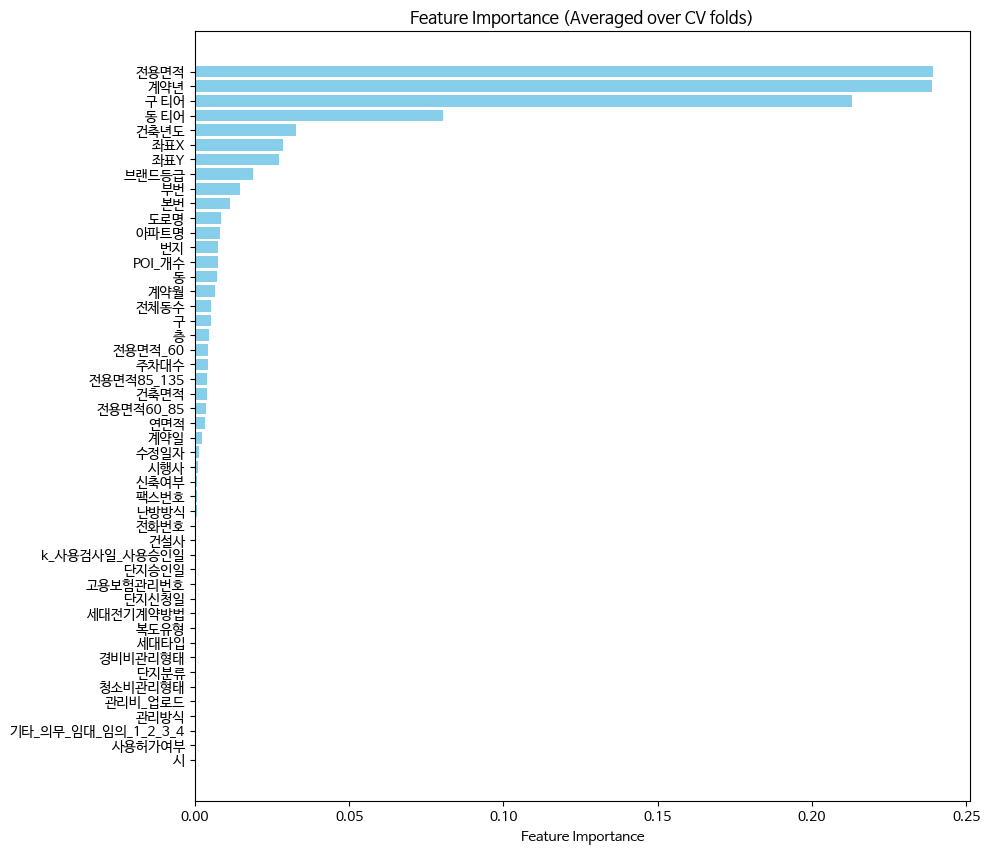

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Averaged over CV folds)')
plt.show()

In [ ]:
# ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§. Pickle ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- Ïñ¥Îñ§ Î≥ÄÏàòÍ∞Ä Ïú†Ïö©Ìïú Î≥ÄÏàòÏù∏ÏßÄ ÌôïÏù∏Ìï¥Î≥¥Í∏∞ ÏúÑÌï¥ permutation selectionÏùÑ Ïù¥Ïö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [ ]:
# # Permutation importance Í≥ÑÏÇ∞
# result = permutation_importance(
#     model,                # ÌïôÏäµÎêú Î™®Îç∏
#     X_val,                # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò ÌäπÏÑ±
#     y_val,                # Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïùò ÌÉÄÍ≤ü
#     scoring="neg_mean_squared_error",   # ÌèâÍ∞Ä ÏßÄÌëú (ÌöåÍ∑Ä Î¨∏Ï†úÏù¥ÎØÄÎ°ú ÏùåÏùò MSE ÏÇ¨Ïö©)
#     n_repeats=3,          # Î∞òÎ≥µ ÌöüÏàò
#     random_state=42
# )

# # Ï§ëÏöîÎèÑ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨ÌïòÏó¨ Ï∂úÎ†•
# importance_df = pd.DataFrame({
#     'feature': X_val.columns,
#     'importance_mean': result.importances_mean,
#     'importance_std': result.importances_std
# }).sort_values(by='importance_mean', ascending=False)

# # Í≤∞Í≥º Ï∂úÎ†•
# print(importance_df)

### 5.4. Valid prediction Î∂ÑÏÑù

- ÏòàÏ∏°Í∞íÏùÑ Î∂ÑÏÑùÌï¥Î≥¥Í∏∞ ÏúÑÌï¥ valid predictionÏùÑ ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [ ]:
# # Validation datasetÏóê targetÍ≥º pred Í∞íÏùÑ Ï±ÑÏõåÏ£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
# X_val['target'] = y_val
# X_val['pred'] = pred

In [ ]:
# # Squared_errorÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìï®ÏàòÎ•º Ï†ïÏùòÌïòÍ≤†ÏäµÎãàÎã§.
# def calculate_se(target, pred):
#     squared_errors = (target - pred) ** 2
#     return squared_errors

# # RMSE Í≥ÑÏÇ∞
# squared_errors = calculate_se(X_val['target'], X_val['pred'])
# X_val['error'] = squared_errors

In [ ]:
# # ErrorÍ∞Ä ÌÅ∞ ÏàúÏÑúÎåÄÎ°ú sorting Ìï¥ Î≥¥Í≤†ÏäµÎãàÎã§.
# X_val_sort = X_val.sort_values(by='error', ascending=False)       # ÎÇ¥Î¶ºÏ∞®Ïàú sorting

In [ ]:
# X_val_sort.head()

- ÏòàÏ∏°ÏùÑ Ïûò ÌïòÏßÄ Î™ªÌïú top 100Í∞úÏùò Îç∞Ïù¥ÌÑ∞ÏôÄ ÏòàÏ∏°ÏùÑ ÏûòÌïú top 100Í∞úÏùò Îç∞Ïù¥ÌÑ∞Î•º ÎπÑÍµêÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [ ]:
# X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # ÏòàÏ∏°ÏùÑ Ïûò ÌïòÏßÄÎ™ªÌïú top 100Í∞úÏùò data
# X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # ÏòàÏ∏°ÏùÑ ÏûòÌïú top 100Í∞úÏùò data

In [ ]:
# # Ìï¥ÏÑùÏùÑ ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎî© Îêú Î≥ÄÏàòÎ•º Î≥µÏõêÌï¥Ï§çÎãàÎã§.
# error_top100 = X_val_sort_top100.copy()
# for column in categorical_columns_v2 :     # ÏïûÏÑú Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©ÏóêÏÑú Ï†ïÏùòÌñàÎçò categorical_columns_v2 Î≤îÏ£ºÌòï Î≥ÄÏàò Î¶¨Ïä§Ìä∏Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
#     error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

# best_top100 = X_val_sort_tail100.copy()
# for column in categorical_columns_v2 :     # ÏïûÏÑú Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©ÏóêÏÑú Ï†ïÏùòÌñàÎçò categorical_columns_v2 Î≤îÏ£ºÌòï Î≥ÄÏàò Î¶¨Ïä§Ìä∏Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
#     best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [ ]:
# display(error_top100.head(1))
# display(best_top100.head(1))

- Ïù¥Ï†ú Î∂ÑÌè¨Î•º ÎπÑÍµêÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [ ]:
# sns.boxplot(data = error_top100, x='target')
# plt.title('The worst top100 predictionÏùò target Î∂ÑÌè¨')
# plt.show()

# sns.boxplot(data = best_top100, x='target', color='orange')
# plt.title('The best top100 predictionÏùò target Î∂ÑÌè¨')
# plt.show()

In [ ]:
# sns.histplot(data = error_top100, x='Ï†ÑÏö©Î©¥Ï†Å', alpha=0.5)
# sns.histplot(data = best_top100, x='Ï†ÑÏö©Î©¥Ï†Å', color='orange', alpha=0.5)
# plt.title('Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨ ÎπÑÍµê')
# plt.show()

## 6. Inference

In [ ]:
dt_test.head(2)      # test datasetÏóê ÎåÄÌïú inferenceÎ•º ÏßÑÌñâÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

Î≤àÏßÄ     Î≥∏Î≤à   Î∂ÄÎ≤à  ÏïÑÌååÌä∏Î™Ö      Ï†ÑÏö©Î©¥Ï†Å  Í≥ÑÏïΩÏùº   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ   ÎèÑÎ°úÎ™Ö  Îã®ÏßÄÎ∂ÑÎ•ò  ...  Ïãú  \
1026850  4264  658.0  1.0   292   79.9700   26   5  1987  5496     1  ...  0   
1026851  4240  651.0  1.0   293  108.2017   15  10  2021   431     1  ...  0   

         Íµ¨  Îèô  Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Íµ¨ Ìã∞Ïñ¥  Îèô Ìã∞Ïñ¥  Ïã†Ï∂ïÏó¨Î∂Ä  POI_Í∞úÏàò  Î∏åÎûúÎìúÎì±Í∏â  
1026850  0  8   16    6     1     1     0       3      1  
1026851  0  8   16    7     1     1     1       4      0  

[2 rows x 49 columns]

: 

In [ ]:
# Ï†ÄÏû•Îêú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏòµÎãàÎã§.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test datasetÏóê ÎåÄÌïú inferenceÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
predicted_log2 = model.predict(X_test)
real_test_pred = np.expm1(predicted_log2)  # ÏõêÎûò Í∞íÏúºÎ°ú Ïó≠Î≥ÄÌôò

[LightGBM] [Warning] Unknown parameter: criterion
CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 18.6 ms


In [ ]:
# %%time
# X_test = dt_test.drop(['target'], axis=1)

# # Test datasetÏóê ÎåÄÌïú inferenceÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
# real_test_pred = model.predict(X_test)

In [ ]:
real_test_pred          # ÏòàÏ∏°Í∞íÎì§Ïù¥ Ï∂úÎ†•Îê®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

array([190361.78993715, 243625.56904713, 224916.07137035, ...,
        80420.25839269,  75137.8496688 ,  71851.65576467])

## 7. Output File Save

In [ ]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Í∏∏Ïù¥Î•º Í∞ÄÏ†∏ÏòµÎãàÎã§
num_test_rows = 9273 - 1  # ÏÉòÌîå ÌååÏùºÏùò Ìñâ ÏàòÏóê ÎßûÏ∂•ÎãàÎã§

# ÏòàÏ∏° Í∞íÏùò Í∏∏Ïù¥Î•º ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Í∏∏Ïù¥Ïóê ÎßûÏ∂•ÎãàÎã§.
# ÎßåÏïΩ ÏòàÏ∏° Í∞íÏù¥ Î∂ÄÏ°±Ìïú Í≤ΩÏö∞ÏóêÎäî 0 ÎòêÎäî ÌèâÍ∑†Í∞íÏúºÎ°ú Ï±ÑÏö∏ Ïàò ÏûàÏäµÎãàÎã§.
if len(real_test_pred) < num_test_rows:
    real_test_pred = np.pad(real_test_pred, (0, num_test_rows - len(real_test_pred)), 'constant', constant_values=real_test_pred.mean())

# ÏïûÏÑú ÏòàÏ∏°Ìïú ÏòàÏ∏°Í∞íÎì§ÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)